In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from src import measures
from src.separator import Separator
from src.cleaner import DoubleStepCleaner

In [5]:
fpath = "/autofs/LSDF/projects/code-vita/Medaka/2018_11/"
fls = os.listdir(fpath)
id = np.random.choice(fls)
img_path = fpath + id + "/scaled_0.5_8bit_cropped_slices.tif"
msk_path = fpath + id + "/heartkidney_scaled_0.5_8bit_cropped_slices.tif"

print(id)

Medaka_566_50-2


In [6]:
img = tifffile.imread(img_path)
msk = tifffile.imread(msk_path)

# img = tifffile.imread("/autofs/LSDF/projects/code-vita/Medaka/2018_11/Medaka_508_33-1/scaled_0.5_8bit_cropped_slices.tif")
# msk = tifffile.imread("/autofs/LSDF/projects/code-vita/Medaka/2018_11/Medaka_508_33-1/heartkidney_scaled_0.5_8bit_cropped_slices.tif")

(2016, 512, 592)


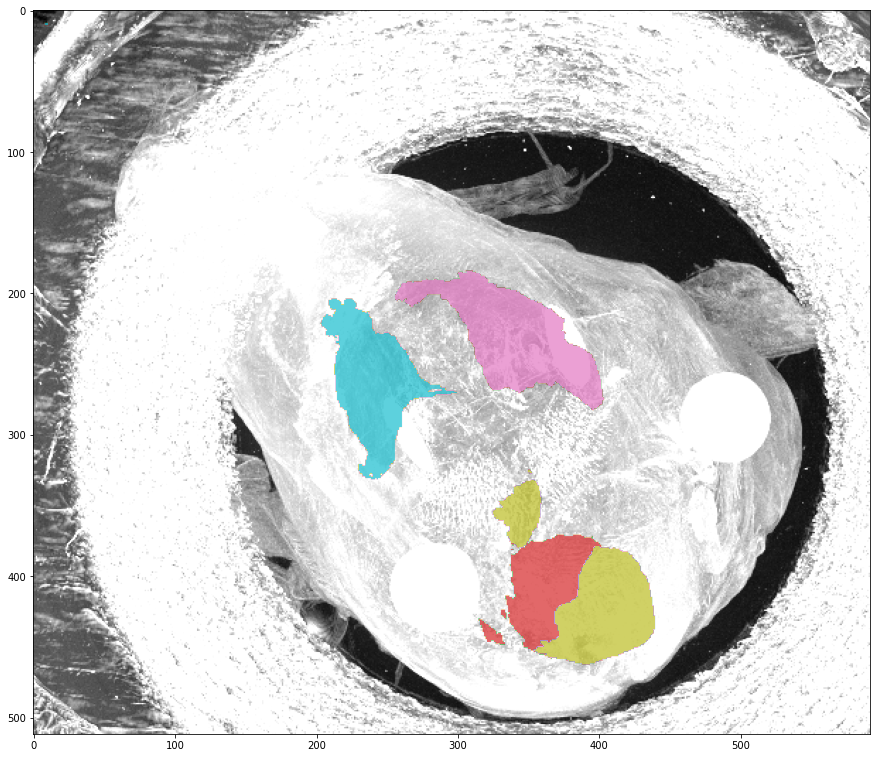

(512, 592, 2016)


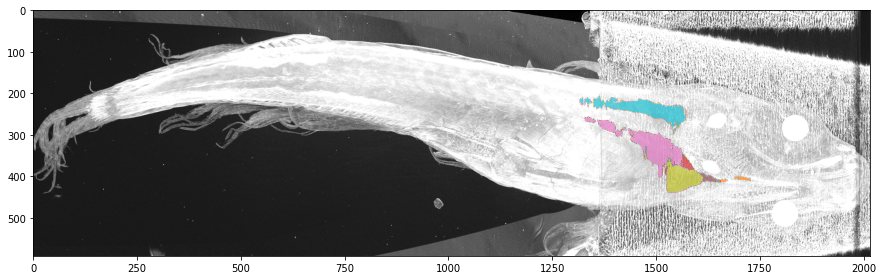

(592, 512, 2016)


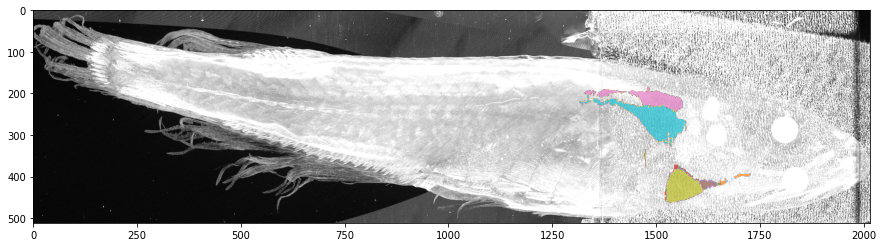

In [7]:
def plot_max(img, msk):
    for ax in range(3):
        img_swap, msk_swap = img.swapaxes(0,ax), msk.swapaxes(0,ax)
        if ax==1:
            img_swap, msk_swap = img_swap.swapaxes(1,2), msk_swap.swapaxes(1,2)
        print(img_swap.shape)
        plt.figure(figsize=(15, 15))
        plt.imshow(np.max(img_swap, axis=0), cmap='gray')
        plt.imshow(np.max(msk_swap, axis=0), cmap='tab10', alpha=(np.max(msk_swap, axis=0)>0)*0.7)
        plt.show()

plot_max(img, msk)

(2016, 512, 592)
[0 0 0]
1547


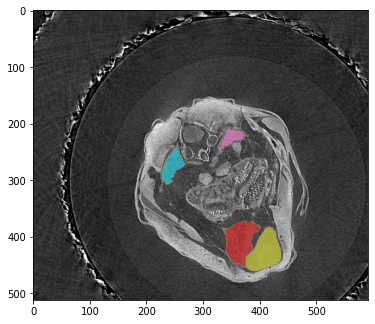

In [8]:
 def plot_slice(img, msk):
    ne_slc = np.where(msk.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    slice_id = np.argmax(msk.sum((1, 2)))

    print(msk.shape)
    print(np.array(msk.shape) - np.array(img.shape))
    print(slice_id)

    plt.figure(figsize=(6, 6))
    plt.imshow(img[slice_id], cmap='gray')
    plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.7)
    plt.show()

plot_slice(img, msk)

In [9]:
cleaning_config = {
    'bounding_boxes': 2,
    'bbox_cleaning_type': '1d',
    'connected_areas_per_label':
        [
            {'id': 1, 'connected_regions': 1},
            {'id': 2, 'connected_regions': 1},
            {'id': 3, 'connected_regions': 1},
            {'id': 4, 'connected_regions': 1},
            {'id': 5, 'connected_regions': 1},
            {'id': 6, 'connected_regions': 1}
        ]
    }

In [10]:
cleaner = DoubleStepCleaner(**cleaning_config)

In [11]:
msk_clean, roi = cleaner(msk)
img_clean = img[roi]

print(roi)
print(msk_clean.shape)

(slice(1316, 1728, None), slice(9, 462, None), slice(8, 439, None))
(412, 453, 431)


In [12]:
for i in range(1,7):
    print((msk_clean==i).sum())

1280
85499
9565
200519
174073
184114


(412, 453, 431)
[0 0 0]
231


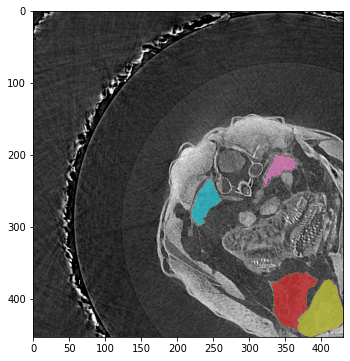

In [13]:
plot_slice(img_clean, msk_clean)

(412, 453, 431)


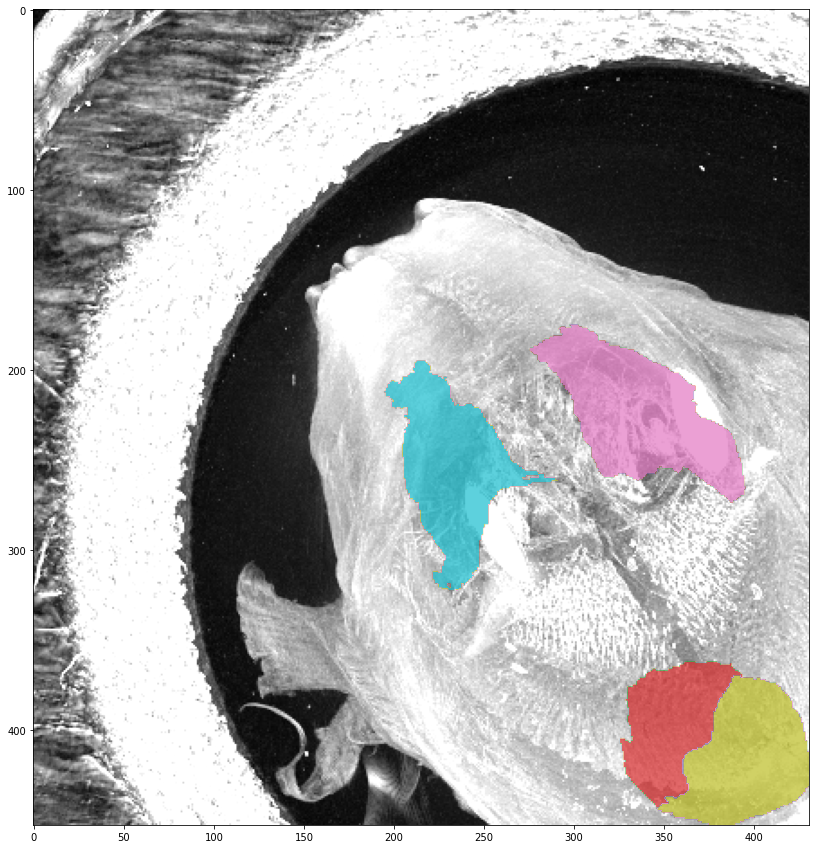

(453, 431, 412)


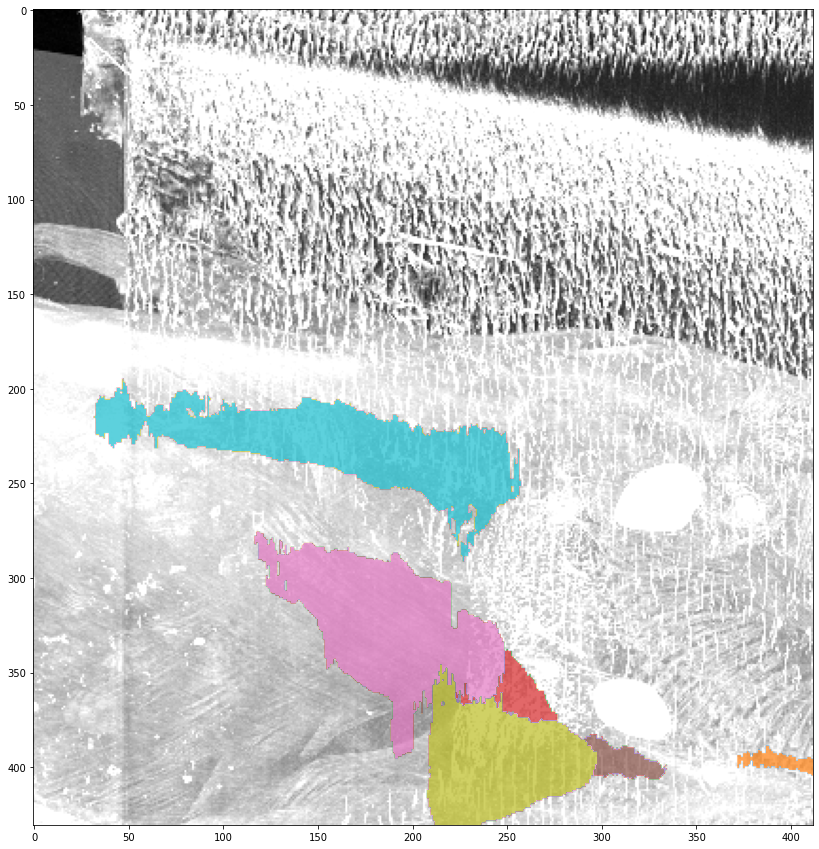

(431, 453, 412)


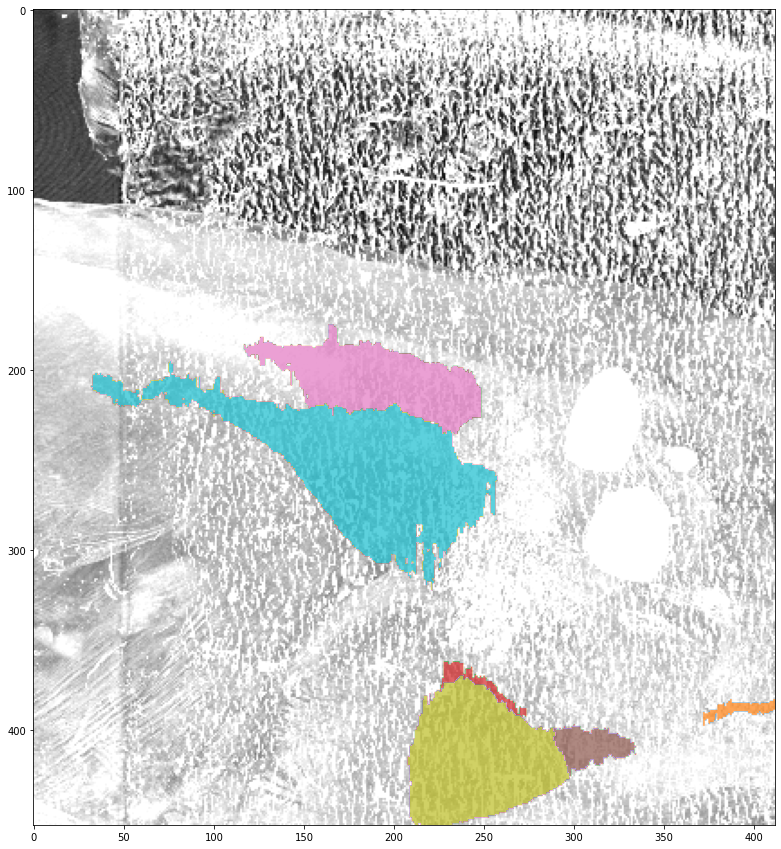

In [14]:
plot_max(img_clean, msk_clean)

In [15]:
# centering_config = [
#     {
#       'label_id': 3,
#       'function': 'proba',
#       'name': 'lens',
#       'count': 2
#     }
# ]

centering_config = []

In [16]:
centers = {}
for centering in centering_config:
    centers[centering['name']] = Separator((msk_clean == centering['label_id']), centering['function'], centering['count'])
    
print(centers)    

{}


In [17]:
measuring_config = [
    {
        'id': 1,
        'name': 'aorta',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'}
        ]
    },
    {
        'id': 2,
        'name': 'atrium',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'eccentricity_equatorial'}
        ]
    },
    {
        'id': 3,
        'name': 'bulbus_arteriousus',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'eccentricity_equatorial'}
        ]
    },
    {
        'id': 4,
        'name': 'left_kidney',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'eccentricity_equatorial'}
        ]
    },
    {
        'id': 5,
        'name': 'ventricle',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'eccentricity_equatorial'}
        ]
    },
    {
        'id': 6,
        'name': 'right_kidney',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'eccentricity_equatorial'}
        ]
    },
]

In [18]:
for label in measuring_config:
    label_mask = (msk_clean == label['id'])
    print(label['id'])
    for measure in label['measures']:
        mf = getattr(measures, measure['function'])
        cc = centers[label['center']] if ('center' in label.keys()) else None
        measurement = mf(label_mask, img_clean, cc)
        print(measure['function'],measurement)

1
volume [1280]
surface_area [1760]
color_average [186.04140625]
color_std [12.04194509921304]
2
volume [85499]
surface_area [38998]
color_average [103.0485385793986]
color_std [23.06023293787359]
eccentricity_meridional [0.23640753865786182]
eccentricity_equatorial [0.05615465096334072]
3
volume [9565]
surface_area [5371]
color_average [142.9338212232096]
color_std [17.10969225734541]
eccentricity_meridional [0.4282111952917868]
eccentricity_equatorial [0.3334658198356258]
4
volume [200519]
surface_area [56444]
color_average [119.29544332457273]
color_std [20.73402028738981]
eccentricity_meridional [0.4860418369984345]
eccentricity_equatorial [0.2612566533178875]
5
volume [174073]
surface_area [35440]
color_average [131.3396620957874]
color_std [17.202527960151546]
eccentricity_meridional [0.16833942110741176]
eccentricity_equatorial [0.062441133881138866]
6
volume [184114]
surface_area [68600]
color_average [122.746711276709]
color_std [21.829593194618607]
eccentricity_meridional [0.